In [3]:
!pip install disarray

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [5]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [6]:
train_path = '/kaggle/input/multiclassoriginalimages/train_directory'
validation_path = '/kaggle/input/multiclassoriginalimages/validation_directory'
test_path = '/kaggle/input/multiclassoriginalimages/test_directory'

In [8]:
preprocess_input = tensorflow.keras.applications.nasnet.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [10]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(192,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

In [11]:
tl_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation_188[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_189[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_191[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_r

 Total params: 4,474,011 (17.07 MB)

 Trainable params: 4,437,273 (16.93 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [13]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=3,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [15]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [16]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight=class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5013 - f1_score: 0.3965 - loss: 12.0018 - precision: 0.6659 - recall: 0.3097 - top_2_accuracy: 0.6913 - top_3_accuracy: 0.8112
Epoch 1: val_categorical_accuracy improved from -inf to 0.51755, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - categorical_accuracy: 0.5015 - f1_score: 0.3968 - loss: 11.9978 - precision: 0.6661 - recall: 0.3101 - top_2_accuracy: 0.6915 - top_3_accuracy: 0.8114 - val_categorical_accuracy: 0.5176 - val_f1_score: 0.4271 - val_loss: 4.3017 - val_precision: 0.5460 - val_recall: 0.3522 - val_top_2_accuracy: 0.6976 - val_top_3_accuracy: 0.8562 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - categorical_accuracy: 0.8041 - f1_score: 0.7992 - loss: 6.1586 - precision: 0.8477 - recall: 0.7568 - top_2_accuracy: 0.9389 - top_3_accuracy: 0.9827
Epoch 2: val_categorical_accuracy did not improve from 0.51755
577/577 ━━━━━━━━━━━━━━━━━━━━ 213s 366

In [17]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

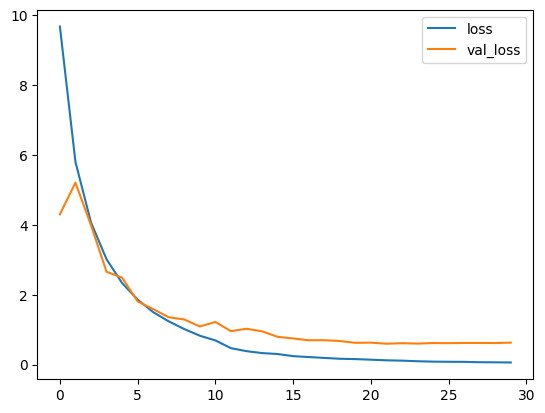

In [18]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

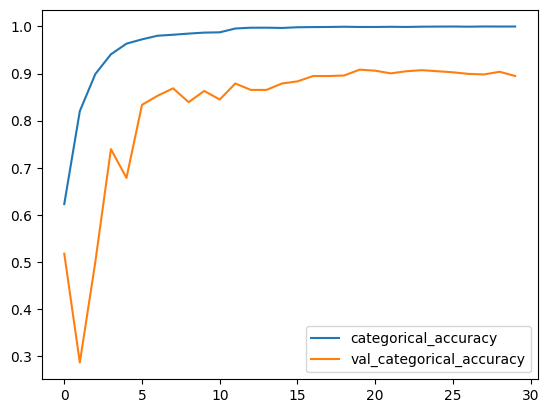

In [19]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

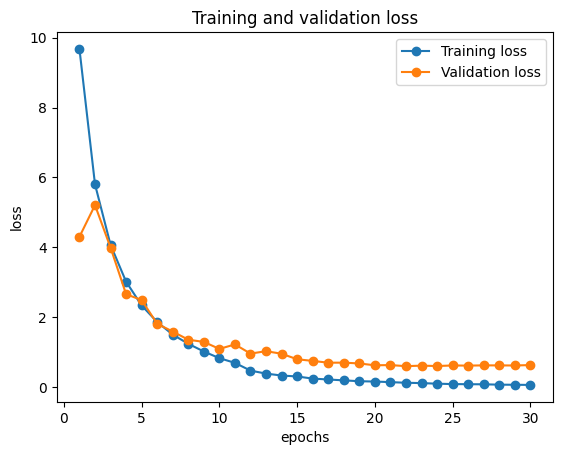

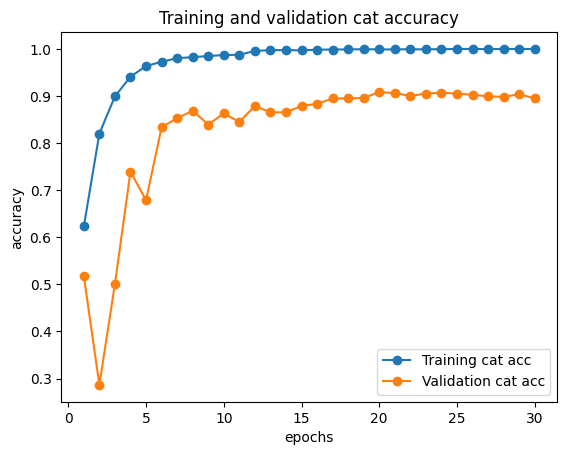

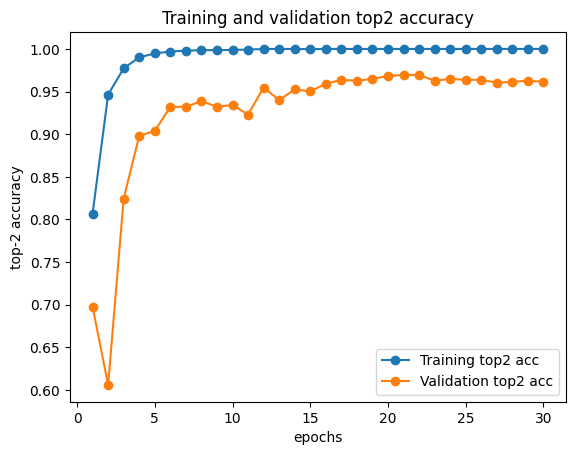

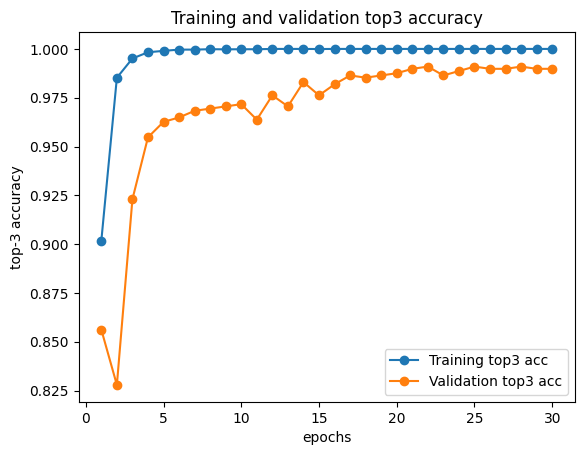

<Figure size 640x480 with 0 Axes>

In [20]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [21]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves_from_generator(predictions, test_labels, class_names):
    """
    Plot ROC curves for predictions from a generator-based model.
    
    Parameters:
    predictions: Raw predictions from model.predict()
    test_labels: True labels from generator.classes
    class_names: List of class names in order matching generator.class_indices
    """
    # Convert predictions to probabilities if not already
    if len(predictions.shape) == 1:  # If predictions are already argmaxed
        # Convert to one-hot
        n_classes = len(class_names)
        y_pred_proba = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            y_pred_proba[i, pred] = 1
    else:
        y_pred_proba = predictions
    
    # Binarize the labels
    y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Store AUC scores
    auc_scores = {}
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    return plt.gcf(), auc_scores

# Best Model Based on Validation Categorical Accuracy

In [22]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [23]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - categorical_accuracy: 0.8358 - f1_score: 0.8367 - loss: 1.0447 - precision: 0.8375 - recall: 0.8359 - top_2_accuracy: 0.9356 - top_3_accuracy: 0.9708
val_loss: 0.6225574612617493
val_cat_acc: 0.9082672595977783
val_top_2_acc: 0.9682899117469788
val_top_3_acc: 0.987542450428009
val_precision: 0.909204363822937
val_recall: 0.908460259437561
val_f1_score 0.9088293313980103


In [24]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [25]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 853ms/step - categorical_accuracy: 0.8178 - f1_score: 0.8204 - loss: 1.1192 - precision: 0.8254 - recall: 0.8156 - top_2_accuracy: 0.9252 - top_3_accuracy: 0.9558
test_loss: 0.631611704826355
test_cat_acc: 0.904805064201355
test_top_2_acc: 0.9637352824211121
test_top_3_acc: 0.9800543785095215
test_precision: 0.9113804697990417
test_recall: 0.9042824506759644
test_f1_score 0.9077820181846619


18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 800ms/step

AUC Scores per class:
akiec: 0.963
bcc: 0.988
bkl: 0.938
df: 0.992
mel: 0.907
nv: 0.971
vasc: 1.000


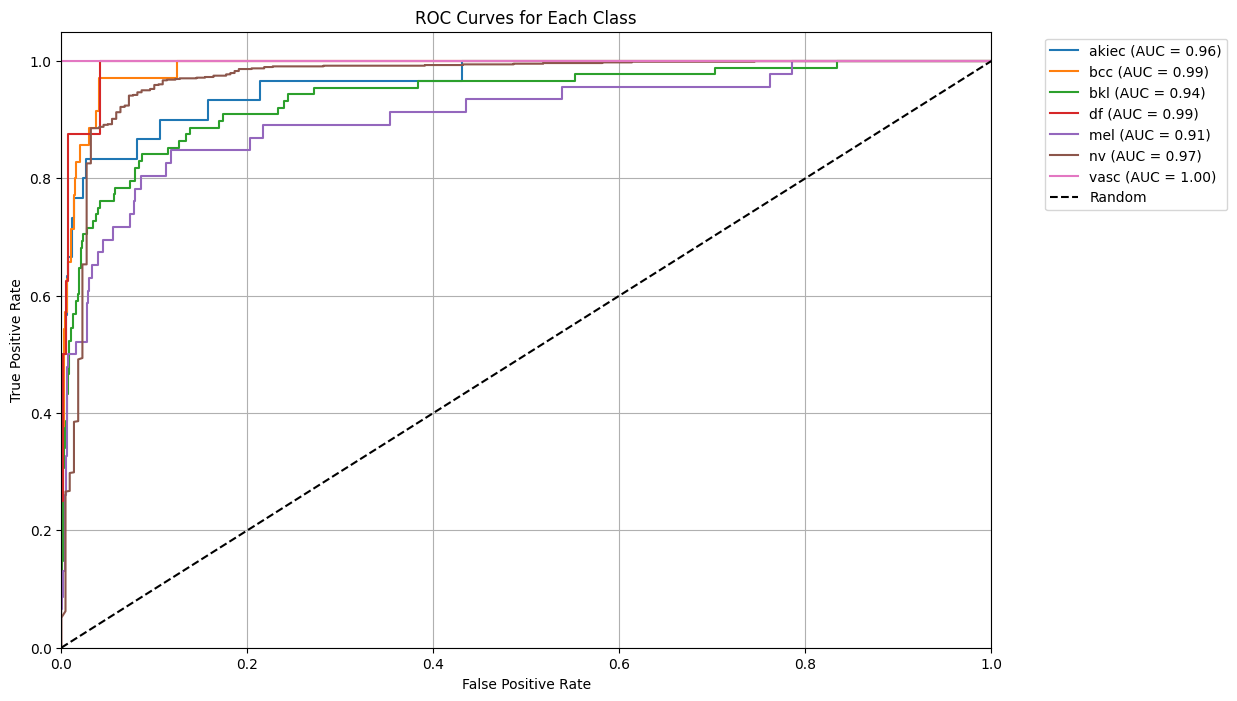

In [27]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

In [28]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step


Normalized confusion matrix
[[0.66666667 0.06666667 0.03333333 0.         0.1        0.13333333
  0.        ]
 [0.14285714 0.77142857 0.05714286 0.         0.         0.02857143
  0.        ]
 [0.02272727 0.05681818 0.57954545 0.01136364 0.11363636 0.21590909
  0.        ]
 [0.125      0.125      0.         0.25       0.125      0.375
  0.        ]
 [0.06521739 0.06521739 0.10869565 0.         0.52173913 0.23913043
  0.        ]
 [0.0011325  0.00566251 0.01019253 0.         0.00792752 0.97508494
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


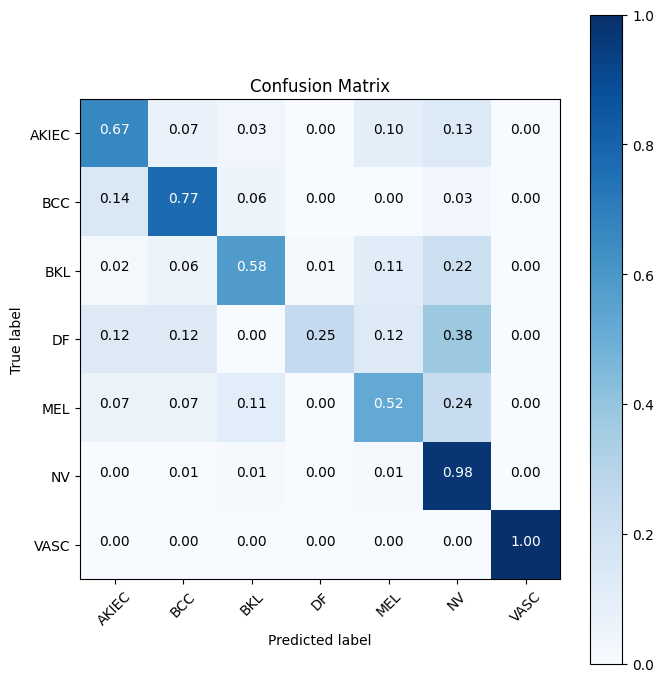

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [30]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.980054,0.978241,0.951043,0.993654,0.961015,0.945603,1.0,0.972801
f1,0.645161,0.692308,0.653846,0.363636,0.527473,0.966330,1.0,0.904805
false_discovery_rate,0.375000,0.372093,0.250000,0.333333,0.466667,0.042269,0.0,0.095195
false_negative_rate,0.333333,0.228571,0.420455,0.750000,0.478261,0.024915,0.0,0.095195
false_positive_rate,0.011184,0.014981,0.016749,0.000913,0.019868,0.172727,0.0,0.015866
negative_predictive_value,0.990663,0.992453,0.964251,0.994545,0.979206,0.892157,1.0,0.984134
positive_predictive_value,0.625000,0.627907,0.750000,0.666667,0.533333,0.957731,1.0,0.904805
precision,0.625000,0.627907,0.750000,0.666667,0.533333,0.957731,1.0,0.904805
recall,0.666667,0.771429,0.579545,0.250000,0.521739,0.975085,1.0,0.904805
sensitivity,0.666667,0.771429,0.579545,0.250000,0.521739,0.975085,1.0,0.904805


# Best Model Based on Validation Loss

In [31]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [32]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - categorical_accuracy: 0.8068 - f1_score: 0.8086 - loss: 1.0869 - precision: 0.8104 - recall: 0.8068 - top_2_accuracy: 0.9342 - top_3_accuracy: 0.9801
val_loss: 0.5976851582527161
val_cat_acc: 0.9003397226333618
val_top_2_acc: 0.9694223999977112
val_top_3_acc: 0.9909399747848511
val_precision: 0.9031279683113098
val_recall: 0.900647759437561
val_f1_score 0.9018780589103699


In [33]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [36]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - categorical_accuracy: 0.8209 - f1_score: 0.8194 - loss: 1.0679 - precision: 0.8227 - recall: 0.8161 - top_2_accuracy: 0.9282 - top_3_accuracy: 0.9746
test_loss: 0.6250383853912354
test_cat_acc: 0.9075249433517456
test_top_2_acc: 0.9637352824211121
test_top_3_acc: 0.9900271892547607
test_precision: 0.9066078662872314
test_recall: 0.9040509462356567
test_f1_score 0.9053032994270325


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step

AUC Scores per class:
akiec: 0.963
bcc: 0.993
bkl: 0.943
df: 0.986
mel: 0.915
nv: 0.971
vasc: 1.000


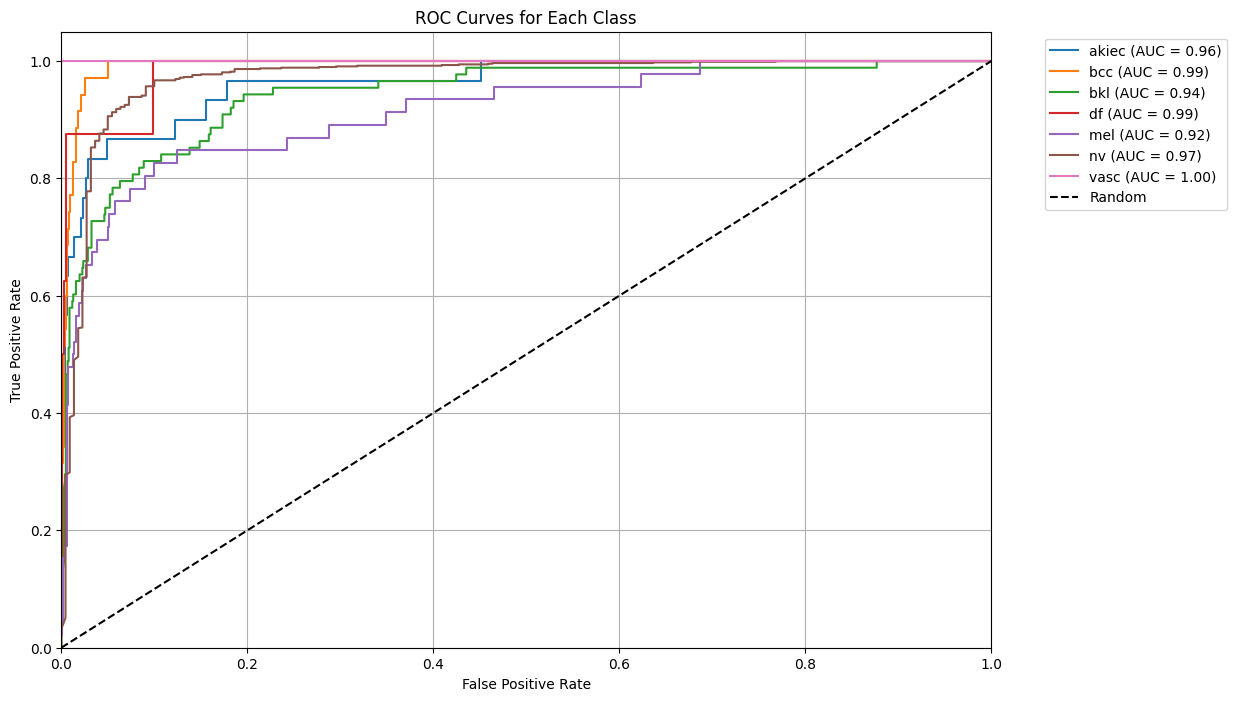

In [34]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves_valloss.png', bbox_inches='tight', dpi=300)
plt.close()

In [35]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step


Normalized confusion matrix
[[0.6        0.03333333 0.06666667 0.         0.1        0.2
  0.        ]
 [0.11428571 0.8        0.05714286 0.         0.         0.02857143
  0.        ]
 [0.01136364 0.06818182 0.60227273 0.01136364 0.09090909 0.21590909
  0.        ]
 [0.         0.25       0.         0.375      0.         0.375
  0.        ]
 [0.02173913 0.02173913 0.15217391 0.         0.5        0.30434783
  0.        ]
 [0.0011325  0.00339751 0.00566251 0.         0.00339751 0.98640997
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


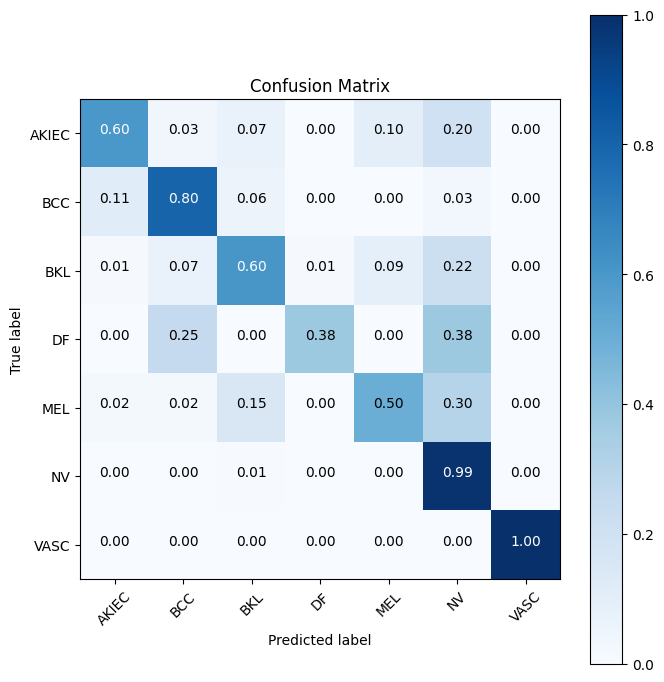

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [37]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.982774,0.981868,0.953762,0.994560,0.966455,0.950136,1.0,0.975651
f1,0.654545,0.736842,0.675159,0.500000,0.554217,0.969393,1.0,0.914778
false_discovery_rate,0.280000,0.317073,0.231884,0.250000,0.378378,0.047046,0.0,0.085222
false_negative_rate,0.400000,0.200000,0.397727,0.625000,0.500000,0.013590,0.0,0.085222
false_positive_rate,0.006524,0.012172,0.015764,0.000913,0.013245,0.195455,0.0,0.014204
negative_predictive_value,0.988868,0.993409,0.966151,0.995450,0.978424,0.936508,1.0,0.985796
positive_predictive_value,0.720000,0.682927,0.768116,0.750000,0.621622,0.952954,1.0,0.914778
precision,0.720000,0.682927,0.768116,0.750000,0.621622,0.952954,1.0,0.914778
recall,0.600000,0.800000,0.602273,0.375000,0.500000,0.986410,1.0,0.914778
sensitivity,0.600000,0.800000,0.602273,0.375000,0.500000,0.986410,1.0,0.914778
